In [1]:
%matplotlib inline
from sklearn import svm
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
x = np.loadtxt("xtrain.txt", delimiter=",")
y = np.loadtxt("ytrain.txt", delimiter=" ")

In [2]:
from sklearn.utils import shuffle
train_size = int(len(x) * 0.8)
x, y = shuffle(x, y, random_state = 0)

xtrain = x[:train_size]
ytrain = y[:train_size]

xtest = x[train_size:]
ytest = y[train_size:]

def print_stats(ypre, ytest, scores):
    # Get Score:
    score = len(filter(lambda x:x[0] == x[1], zip(ypre,ytest)))

    nsCorrect = filter(lambda x:x[0] == x[1] and x[0] == 1 , zip(ypre,ytest))
#     print('# of true positives: %s'% len(nsCorrect))
    nsPred = filter(lambda x: x==1, ypre)
#     print('# predicted positives: %s'% len(nsPred))

    nsActual = filter(lambda x: x==1, ytest)
#     print 'Number of actual No-Shows: %s' %len(nsActual)
    print 'Accuracy: %s' % (score*1.0/len(ytest))
    print('PPV: %s'%(len(nsCorrect)*1.0/len(nsPred))) # TP / (TP+FP)
    print 'Sensitivity or TPR : %s' % (len(nsCorrect)*1.0/(len(nsActual))) #TP / P
    
    fpr, tpr, thresholds = roc_curve(ytest, scores)
    print 'AUROC: %s' % roc_auc_score(ytest, scores)
#     print('FPR: %s' % fpr)
#     print('TPR: %s' % tpr)
#     print('Thresholds: %s' % thresholds)

In [3]:
from itertools import izip

def plotRocStats(ytest, scores, th= []):
    fpr, tpr, thresholds = roc_curve(ytest, scores)
    
    # ROC
    plt.figure(0)
    plt.clf()
    random,= plt.plot(np.arange(0,1,0.001),np.arange(0,1,0.001), label="Random")
    plt.title('ROC')
    model, = plt.plot(fpr,tpr, label="Model")
#     plt.legend(handles=[model,random],loc=4)
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    
    # Metrics vs Threshold
    plt.figure(1)
    plt.clf()
    plt.title('Metrics V.S. Threshold ')
    tpr_plot, = plt.plot(thresholds, tpr, label='TPR')
    fpr_plot, = plt.plot(thresholds, fpr, label='FPR')
    
    # Accuracy
    ppvs= []
    accs = []
    for t in th:
        ypre = map(lambda score: 0 if score <= t else 1, scores)
        truePositives = len(filter(lambda x:x[0] == x[1] and x[0] == 1 , izip(ypre,ytest)))
        positivePreds = len(filter(lambda x: x==1, ypre))
        ppvs.append(truePositives*1.0/positivePreds)

        acc = len(filter(lambda x:x[0] == x[1], izip(ypre,ytest)))
        accs.append(acc*1.0/len(ytest))
    acc_plot, = plt.plot(th, accs, label='Accuracy')
    ppv_plot, = plt.plot(th, ppvs, label='PPV')
    plt.ylabel("Percentage")
    plt.xlabel("Thresholds")
    plt.show()

# Linear SVM

In [5]:
# Train
# clf = svm.SVC(kernel='linear', C = 1.0)
# for c in [0.01, 0.1, 0.3, 0.5, 1]:
for c in [0.3]:
    print "------------ C =  %s ------------" % c
    clf = svm.LinearSVC(dual=False, C = c)
    clf.fit(xtrain,ytrain)

    # Predict
    ypre = clf.predict(xtest)

    # Get Score
#     score = len(filter(lambda x:x[0] == x[1], zip(ypre,ytest)))

    print_stats(ypre, ytest, clf.decision_function(xtest))

------------ C =  0.3 ------------
Accuracy: 0.858542200089
PPV: 0.573268921095
Sensitivity or TPR : 0.0582365450679
AUROC: 0.773727301977


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=5)
clf = clf.fit(xtrain, ytrain)

# Predict
ypre = clf.predict(xtest)
print_stats(ypre, ytest)

# Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
# Create and fit an AdaBoosted decision tree
# for c in [1, 3, 5, 7, 10]:
for c in [ 5]:
    print "------------ C =  %s ------------" % c
    bdt = AdaBoostClassifier(RandomForestClassifier(),algorithm="SAMME", n_estimators=c)
    bdt.fit(xtrain, ytrain)

    ypre = bdt.predict(xtest)
    scores = bdt.decision_function(xtest)
    print_stats(ypre, ytest, scores)

### Linear SVC as Base

In [ ]:
bdt = AdaBoostClassifier(svm.SVC(probability=True,kernel='linear'),n_estimators=5, learning_rate=1.0, algorithm='SAMME')
bdt.fit(xtrain, ytrain)
ypre = bdt.predict(xtest)
scores = bdt.decision_function(xtest)
print_stats(ypre, ytest, scores)

### Decision Tree Classifier as Base

In [10]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
# for c in [5,6]:
for c in [ 5]:
    print "------------ C =  %s ------------" % c
    bdt = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=c),
        n_estimators=15)
    bdt.fit(xtrain, ytrain)
    ypre = bdt.predict(xtest)
    scores = bdt.decision_function(xtest)
    print_stats(ypre, ytest, scores)

------------ C =  5 ------------
Accuracy: 0.865777172253
PPV: 0.586475942783
Sensitivity or TPR : 0.221331588418
AUROC: 0.845843907953
------------ C =  6 ------------
Accuracy: 0.865965093608
PPV: 0.579029126214
Sensitivity or TPR : 0.243906428922
AUROC: 0.840446792496


In [ ]:
plotRocStats(ytest, scores)

In [ ]:
print_stats([0 if scores[i]<= -0.15 else 1 for i in xrange(len(pred))], ytest, scores)

# GBRT

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
   max_depth=1, random_state=0).fit(xtrain, ytrain)
ypre = clf.predict(xtest)

print_stats(ypre, ytest)

# XGBoost

Results:
 - d = 15, n = 50: high train auc (90%) but low test auc -> 0.694
 - d = 10, n = 50: test auc 0.713
 - d = 10, n = 100: test auc 0.716022415248
 - d= 5, n= 50: test auc: 0.7045
 - d = 5, n = 100: test auc 0.715

In [4]:
import xgboost as xgb
xg_train = xgb.DMatrix(xtrain, label=ytrain, feature_names=None)
xg_test = xgb.DMatrix(xtest, label=ytest)

## setup parameters for xgboost
param = {}
param['objective'] = 'binary:logistic'
param['eta'] = 0.1
param['max_depth'] = 5
param['silent'] = 1
# param['nthread'] = 4 # comment to use max num of threads
param['eval_metric'] ='auc'
param['scale_pos_weight'] = 47747*1.0/7836 # scaled by calculating ratio of pos to neg
watchlist = [ (xg_train,'train'), (xg_test, 'test') ]
num_round = 100
bst = xgb.train(param, xg_train, num_round, watchlist)


### get prediction
pred = bst.predict( xg_test )
print_stats([0 if pred[i]<= 0.65 else 1 for i in xrange(len(pred))], ytest, pred)

Accuracy: 0.816917619976
PPV: 0.408152114523
Sensitivity or TPR : 0.610992965811
AUROC: 0.851431149614


In [26]:
import ast
def read_mapping():
    with open('mapping.txt', 'r') as f:
        s = f.read()
        return ast.literal_eval(s)
    
def getByValue(d, v):
    for key, val in d.iteritems():
        if val == v:
            return key
    
asd = sorted(bst.get_fscore().items(), key=lambda x:x[1], reverse=True)[:10]
mapping = read_mapping()
qualitative_size = len(mapping)
# Days of week
quantitative = [i+1 for i in range(7)] + ["Appointment Time", "Appointment Waiting Time (days)", "Age", "NS History"]
print asd
canon = [quantitative[int(key[1:]) - qualitative_size] if int(key[1:]) >= qualitative_size else getByValue(mapping, int(key[1:])) for key, val in asd]
zip(canon, asd)

[('f339', 372), ('f341', 255), ('f340', 245), ('f338', 95), ('f6', 93), ('f53', 64), ('f124', 48), ('f8', 46), ('f49', 42), ('f37', 38)]


[('Appointment Waiting Time (days)', ('f339', 372)),
 ('NS History', ('f341', 255)),
 ('Age', ('f340', 245)),
 ('Appointment Time', ('f338', 95)),
 ('fp', ('f6', 93)),
 ('nc', ('f53', 64)),
 ('nf', ('f124', 48)),
 ('chinese', ('f8', 46)),
 ('oral & maxillo-facial surgery', ('f49', 42)),
 ('22', ('f37', 38))]

In [50]:
 print_stats([0 if pred[i]<= 0.65 else 1 for i in xrange(len(pred))], ytest, pred)

Accuracy: 0.816917619976
PPV: 0.408152114523
Sensitivity or TPR : 0.610992965811
AUROC: 0.851431149614


In [13]:
print_stats([0 if pred[i]<= 0.91 else 1 for i in xrange(len(pred))], ytest, pred)

Accuracy: 0.860045570929
PPV: 0.741433021807
Sensitivity or TPR : 0.0389334205791
AUROC: 0.851431149614


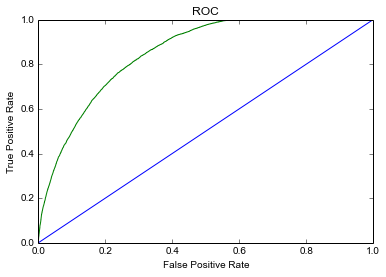

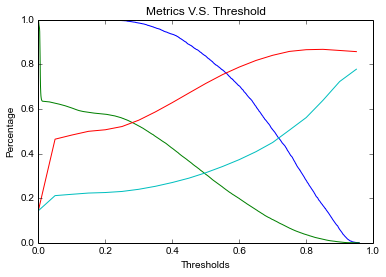

In [57]:
plotRocStats(ytest, pred, th= np.arange(0,1,0.05))

# Percentage of no shows

In [ ]:
score = len(filter(lambda x:x == -1, ytest))
    
print score*1.0/len(ytest)